In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

TEST2

# test

In [2]:
features = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [3]:
flu_df = pd.merge(features, labels, on='respondent_id', how='outer')

In [4]:
flu_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [5]:
flu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
X=flu_df.drop('seasonal_vaccine', axis=1)
y=flu_df['seasonal_vaccine']

In [7]:
print(X.columns
)

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine'],
      dtype='object')


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=12)

In [9]:
numbers=['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
onehots=['race', 'sex',  'marital_status', 'income_poverty', 'age_group', 'education', 'rent_or_own','employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
binary= ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'h1n1_vaccine']

In [10]:
numbers_pipeline = Pipeline(steps=[
    ('impute_nums', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('num', StandardScaler())])

In [11]:
onehots_pipeline = Pipeline(steps=[
    ('impute_ohe', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [12]:
binary_pipeline = Pipeline(steps=[('impute_bin', SimpleImputer(strategy='most_frequent', add_indicator=True))])

In [13]:
col_tr = ColumnTransformer(transformers=[('num', numbers_pipeline, numbers),
                                        ('ohe', onehots_pipeline, onehots),
                                        ('bin', binary_pipeline, binary)],
                          remainder='drop', sparse_threshold=0)

In [14]:

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
dummy.score(X_train, y_train)

0.5326510234648028

# Decision Tree

In [16]:
tree_pipe = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12))])

In [17]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [18]:
cv_results = cross_validate(estimator=tree_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([0.64538431, 0.64066482, 0.63542199, 0.63946509, 0.63588476]),
 'score_time': array([0.01774597, 0.01713419, 0.0167501 , 0.01666188, 0.01663923]),
 'test_score': array([0.71018472, 0.70968547, 0.72241638, 0.71867199, 0.71767349]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [19]:
tree_y_train = tree_pipe.predict(X_train)
tree_y_pred = tree_pipe.predict(X_test)

In [20]:
print(precision_score(y_train, tree_y_train))
print(precision_score(y_test, tree_y_pred))

1.0
0.6860133206470028


In [21]:
tree_pipe = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12, max_depth=7))])

In [22]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [23]:
cv_results = cross_validate(estimator=tree_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([0.56026292, 0.55300474, 0.55590296, 0.55378199, 0.55185795]),
 'score_time': array([0.016608  , 0.01671028, 0.01648116, 0.01626492, 0.01616502]),
 'test_score': array([0.77858213, 0.77333999, 0.78582127, 0.78032951, 0.78082876]),
 'train_score': array([0.80029955, 0.8007988 , 0.80054918, 0.80048677, 0.8007364 ])}

In [24]:
tree_y_train = tree_pipe.predict(X_train)
tree_y_pred = tree_pipe.predict(X_test)

In [25]:
print(precision_score(y_train, tree_y_train))
print(precision_score(y_test, tree_y_pred))

0.7993498486716736
0.7915804002760525


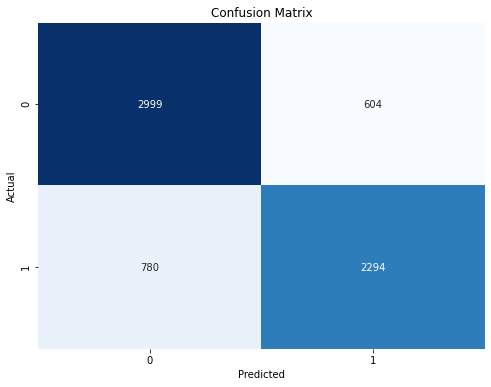

In [26]:
cm = confusion_matrix(y_test, tree_y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [27]:
X_train_tr = col_tr.fit_transform(X_train)
X_test_tr = col_tr.transform(X_test)

In [28]:
from sklearn.model_selection import GridSearchCV

log_pipe = Pipeline([
    ('logistic', LogisticRegression(max_iter=1000))
])


param_grid = {'logistic__C': [0.001, 0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(log_pipe, param_grid, cv=5, scoring='f1')

grid_search.fit(X_train_tr, y_train)

best_C = grid_search.best_params_['logistic__C']
best_f1_score = grid_search.best_score_

final_model = Pipeline([
    ('logistic', LogisticRegression(C=best_C, max_iter=1000))
])
final_model.fit(X_train_tr, y_train)

Pipeline(steps=[('logistic', LogisticRegression(C=1, max_iter=1000))])

In [29]:
cv_log_results = cross_validate(estimator= final_model, X=X_train_tr, y=y_train, cv=5,
                            return_train_score=True)
cv_log_results

{'fit_time': array([0.53745103, 0.5748601 , 0.57510185, 0.52424717, 0.51656818]),
 'score_time': array([0.00060105, 0.00056195, 0.00062418, 0.00058484, 0.00059009]),
 'test_score': array([0.79081378, 0.7998003 , 0.8017973 , 0.79605592, 0.80129805]),
 'train_score': array([0.80410634, 0.80086121, 0.80036196, 0.80416875, 0.80279581])}

In [30]:
y_train_pred = final_model.predict(X_train_tr)
y_test_pred = final_model.predict(X_test_tr)

In [31]:
print(precision_score(y_train, y_train_pred))
print(precision_score(y_test, y_test_pred))

0.8041120650700406
0.803076923076923


In [32]:
f1 = f1_score(y_test, y_test_pred)
f1

0.7831305217536255

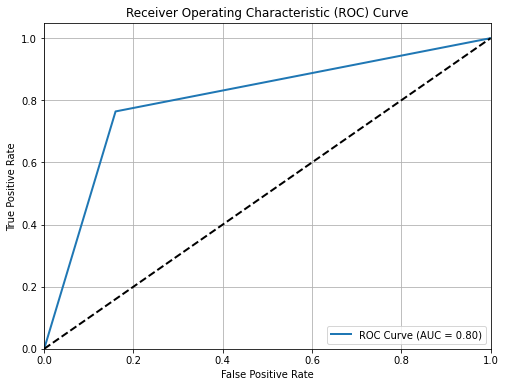

In [33]:
roc_auc = roc_auc_score(y_test, y_test_pred)


fpr, tpr, _ = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(final_model, X_train_tr, y_train, cv=5, scoring='accuracy')

In [35]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Standard Deviation of Accuracy: {std_accuracy}') #low std: consistency, reliability, generalization

Mean Accuracy: 0.7979530703944084
Standard Deviation of Accuracy: 0.004097510639776977


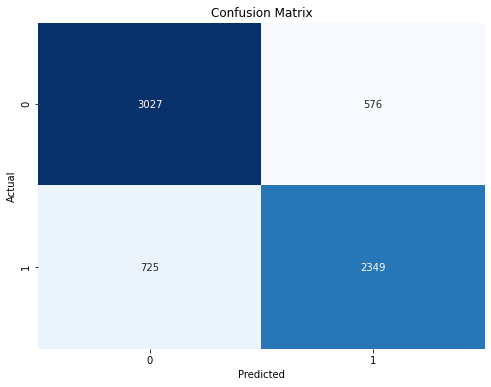

In [36]:
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
final_model.named_steps

{'logistic': LogisticRegression(C=1, max_iter=1000)}

In [38]:
coeff = final_model.named_steps['logistic'].coef_
len(coeff[0])

143

In [39]:
obj = list(col_tr.named_transformers_['ohe'].named_steps['ohe'].get_feature_names())
len(obj)

96

In [40]:
num_ind = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']

In [41]:
num_ind = []
for name in numbers:
    new_name = name+"_indicator"
    num_ind.append(new_name)
print(num_ind)

['h1n1_concern_indicator', 'h1n1_knowledge_indicator', 'opinion_h1n1_vacc_effective_indicator', 'opinion_h1n1_risk_indicator', 'opinion_h1n1_sick_from_vacc_indicator', 'opinion_seas_vacc_effective_indicator', 'opinion_seas_risk_indicator', 'opinion_seas_sick_from_vacc_indicator', 'household_adults_indicator', 'household_children_indicator']


In [42]:
final_num = numbers + num_ind

In [43]:
final_num_cat =  final_num + obj

In [44]:
bin_ind = []

for name in binary:
    new_name = name+'_indicator'
    bin_ind.append(new_name)

bin_ind.remove('h1n1_vaccine_indicator')
print(bin_ind)

['behavioral_antiviral_meds_indicator', 'behavioral_avoidance_indicator', 'behavioral_face_mask_indicator', 'behavioral_wash_hands_indicator', 'behavioral_large_gatherings_indicator', 'behavioral_outside_home_indicator', 'behavioral_touch_face_indicator', 'doctor_recc_h1n1_indicator', 'doctor_recc_seasonal_indicator', 'chronic_med_condition_indicator', 'child_under_6_months_indicator', 'health_worker_indicator', 'health_insurance_indicator']


In [45]:
final_bin = binary + bin_ind

In [46]:
logreg_estimator = final_model.named_steps['logistic']


coefficients = logreg_estimator.coef_
intercept = logreg_estimator.intercept_

feature_names = final_num_cat + final_bin 

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
sorted_coef = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


print(sorted_coef.head(10))


                         Feature  Coefficient  Abs_Coefficient
129                 h1n1_vaccine     1.892155         1.892155
124         doctor_recc_seasonal     1.570638         1.570638
63                  x10_haxffmxo     1.345565         1.345565
82                  x11_dcjcmpih     1.345565         1.345565
35                  x4_65+ Years     0.937958         0.937958
123             doctor_recc_h1n1    -0.880296         0.880296
6              opinion_seas_risk     0.730232         0.730232
67                  x10_msuufmds     0.718882         0.718882
73                  x10_saaquncn    -0.667711         0.667711
5    opinion_seas_vacc_effective     0.635440         0.635440
